In [39]:
pip install pyarrow


     ---------------------------------------- 20.5/20.5 MB 7.4 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
import seaborn as sns
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as t
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt

In [2]:
# инициализируем спарк-сессию
spark = SparkSession.builder.getOrCreate()

In [3]:
spark

In [5]:
# читаем файл со схемой для правильной загрузки типов данных
df = spark.read.format('csv').option('header', 'true').load('C://Users/Uldum/Downloads/clustering_test_work.csv', inferSchema =True)

In [11]:
df.show(2, vertical=True)

-RECORD 0----------------------------------
 _c0                 | 0                   
 actual_id           | 12013601421         
 period_end          | 2021-02-19 00:00:00 
 num                 | 2                   
 revenue_lastyear    | 17920.0             
 quantity_lastyear   | 4                   
 orders_lastyear     | 1                   
 orders_refund       | 0                   
 ratio_not_dh        | 1.0                 
 ratio_online        | 1.0                 
 ratio_refund        | 0.0                 
 avg_ratio_purchase  | 0.8                 
 quantity_1st_period | 4.0                 
 unigenders          | 1                   
 recency             | 123                 
 aov                 | 17920.0             
-RECORD 1----------------------------------
 _c0                 | 1                   
 actual_id           | 12013601421         
 period_end          | 2021-04-19 00:00:00 
 num                 | 3                   
 revenue_lastyear    | 17920.0  

In [19]:
df.select(F.col('actual_id'), F.col('period_end')).show(5)

+-----------+----------+
|  actual_id|period_end|
+-----------+----------+
|12013601421|2021-02-19|
|12013601421|2021-04-19|
|12013601421|2021-06-19|
|12013601421|2021-08-19|
|12013601421|2021-10-19|
+-----------+----------+
only showing top 5 rows



In [6]:
# подзапрос с фильтрацией
param = 0

subq = df.select(F.col('actual_id'), F.col('period_end'), F.col('aov')).filter(F.col('period_end') == "2022-12-07")\
.filter(F.col('aov') > param)
subq.show(5)

+-----------+----------+-------+
|  actual_id|period_end|    aov|
+-----------+----------+-------+
|12013960666|2022-12-07|27960.0|
|12063704219|2022-12-07|10960.0|
|12068234221|2022-12-07| 7480.0|
|12069928477|2022-12-07|24960.0|
|12124564545|2022-12-07|15980.0|
+-----------+----------+-------+
only showing top 5 rows



In [34]:
# подсчёт строк в датафрейме
df.count()

2247574

In [41]:
# подсчёт различных значений в столбце
df.select(F.col('period_end')).distinct().count()

690

In [19]:
# группировка по значению в столбце с подсчётом вхождений каждого значения
df.groupby('actual_id').count().orderBy(F.col('count').desc()).show(2)

+-----------+-----+
|  actual_id|count|
+-----------+-----+
|77017111445|   13|
|79029403830|   13|
+-----------+-----+
only showing top 2 rows



In [49]:
# переименование колонки
df.withColumnRenamed('_c0', 'row_id').select('row_id').show(4)

+------+
|row_id|
+------+
|     0|
|     1|
|     2|
|     3|
+------+
only showing top 4 rows



In [51]:
# создание новой колонки по старой
df.withColumn('row_id', F.col('_c0')+1).select('_c0', 'row_id').show(5)

+---+------+
|_c0|row_id|
+---+------+
|  0|   1.0|
|  1|   2.0|
|  2|   3.0|
|  3|   4.0|
|  4|   5.0|
+---+------+
only showing top 5 rows



In [8]:
# схема дф
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- actual_id: long (nullable = true)
 |-- period_end: timestamp (nullable = true)
 |-- num: integer (nullable = true)
 |-- revenue_lastyear: double (nullable = true)
 |-- quantity_lastyear: integer (nullable = true)
 |-- orders_lastyear: integer (nullable = true)
 |-- orders_refund: integer (nullable = true)
 |-- ratio_not_dh: double (nullable = true)
 |-- ratio_online: double (nullable = true)
 |-- ratio_refund: double (nullable = true)
 |-- avg_ratio_purchase: double (nullable = true)
 |-- quantity_1st_period: double (nullable = true)
 |-- unigenders: integer (nullable = true)
 |-- recency: integer (nullable = true)
 |-- aov: double (nullable = true)



In [7]:
# основные показатели колонок
subq.describe().show()

+-------+--------------------+----------+------------------+
|summary|           actual_id|period_end|               aov|
+-------+--------------------+----------+------------------+
|  count|              182745|    182745|            182745|
|   mean|3.476121477177607...|      null|15283.717338808337|
| stddev|7.082808410889412E13|      null|13092.503945192891|
|    min|         12013960666|2022-12-07|            1000.0|
|    max|        998998908989|2022-12-07| 9999.833333333334|
+-------+--------------------+----------+------------------+



In [54]:
# остановка спарк-сессии
spark.stop()

In [50]:
# небольшая функия-пайплайн с записью файла
def main():
    SparkSession.builder.getOrCreate()
    df = spark.read.format('csv').option('header', 'true').load('C://Users/Uldum/Downloads/clustering_test_work.csv')
    prechurn = (
        df.filter(F.col('period_end') == '2022-12-07')
        .filter(F.col('recency') <= 365)
        .filter(F.col('recency') > 300)
    )
    
    out = (
        prechurn
        .groupBy('unigenders')
        .agg(
            F.count('actual_id').alias('Count'),
            F.round(F.avg(F.col('aov').cast(t.IntegerType()))).alias('Avg'),
            F.round(F.sum(F.col('aov').cast(t.IntegerType()))).alias('Sum'),
            F.max(F.col('aov').cast(t.IntegerType())).alias('Max')
        )
            
    )

    print(prechurn.select(F.col('actual_id')).distinct().count())
    print(out.show(5))
    prechurn.coalesce(1).write.format('csv').save('mycsv.csv')
    
main()

25156
+----------+-----+-------+---------+------+
|unigenders|Count|    Avg|      Sum|   Max|
+----------+-----+-------+---------+------+
|         1|24394|13071.0|318856956|228640|
|         2|  762|17975.0| 13697243|235660|
+----------+-----+-------+---------+------+

None


In [6]:
# фильтрация по значению в колонке, сброс дубликатов строк
df_1 = df.filter(F.col('period_end') == '2022-12-07')
df_1 = df_1.dropDuplicates()
df_1.show(2, vertical=True)

-RECORD 0----------------------------------
 _c0                 | 2671                
 actual_id           | 2978903284907       
 period_end          | 2022-12-07 00:00:00 
 num                 | 9                   
 revenue_lastyear    | 0.0                 
 quantity_lastyear   | 0                   
 orders_lastyear     | 0                   
 orders_refund       | 0                   
 ratio_not_dh        | 0.0                 
 ratio_online        | 0.0                 
 ratio_refund        | 0.0                 
 avg_ratio_purchase  | 1.0                 
 quantity_1st_period | 2.0                 
 unigenders          | 1                   
 recency             | 524                 
 aov                 | 0.0                 
-RECORD 1----------------------------------
 _c0                 | 2677                
 actual_id           | 2978903311588       
 period_end          | 2022-12-07 00:00:00 
 num                 | 7                   
 revenue_lastyear    | 0.0      

In [5]:
#!!!! ПРОВЕРКА НА НАЛИЧИЕ ПРОПУЩЕННЫХ И НУЛЕВЫХ ЗНАЧЕНИЙ В ДАТАФРЕЙМЕ!!!!
df_1.select(*[
    (
        F.count(F.when((F.isnan(c) | F.col(c).isNull()), c)) if t not in ("timestamp", "date")
        else F.count(F.when(F.col(c).isNull(), c))
    ).alias(c)
    for c, t in df.dtypes if c in df_1.columns
]).show(vertical=True)

-RECORD 0------------------
 _c0                 | 0   
 actual_id           | 0   
 period_end          | 0   
 num                 | 0   
 revenue_lastyear    | 0   
 quantity_lastyear   | 0   
 orders_lastyear     | 0   
 orders_refund       | 0   
 ratio_not_dh        | 0   
 ratio_online        | 0   
 ratio_refund        | 0   
 avg_ratio_purchase  | 0   
 quantity_1st_period | 0   
 unigenders          | 0   
 recency             | 0   
 aov                 | 0   



In [7]:
# создание новой колонки (целевой) по другой колонке с заполнением значений по условию
df_1 = df_1.withColumn("target", \
              F.when(df_1["recency"] >= 365, 1).otherwise(0))

In [8]:
df_1.show(2, vertical=True)

-RECORD 0----------------------------------
 _c0                 | 11                  
 actual_id           | 12013601421         
 period_end          | 2022-12-07 00:00:00 
 num                 | 13                  
 revenue_lastyear    | 0.0                 
 quantity_lastyear   | 0                   
 orders_lastyear     | 0                   
 orders_refund       | 0                   
 ratio_not_dh        | 0.0                 
 ratio_online        | 0.0                 
 ratio_refund        | 0.0                 
 avg_ratio_purchase  | 1.0                 
 quantity_1st_period | 4.0                 
 unigenders          | 1                   
 recency             | 779                 
 aov                 | 0.0                 
 target              | 1                   
-RECORD 1----------------------------------
 _c0                 | 16                  
 actual_id           | 12013960666         
 period_end          | 2022-12-07 00:00:00 
 num                 | 6        

In [8]:
# сброс ненужных колонок
df_1 = df_1.drop('_c0', 'actual_id', 'period_end', 'recency')
df_1.show(2, vertical=True)

-RECORD 0------------------
 num                 | 9   
 revenue_lastyear    | 0.0 
 quantity_lastyear   | 0   
 orders_lastyear     | 0   
 orders_refund       | 0   
 ratio_not_dh        | 0.0 
 ratio_online        | 0.0 
 ratio_refund        | 0.0 
 avg_ratio_purchase  | 1.0 
 quantity_1st_period | 2.0 
 unigenders          | 1   
 aov                 | 0.0 
 target              | 1   
-RECORD 1------------------
 num                 | 7   
 revenue_lastyear    | 0.0 
 quantity_lastyear   | 0   
 orders_lastyear     | 0   
 orders_refund       | 0   
 ratio_not_dh        | 0.0 
 ratio_online        | 0.0 
 ratio_refund        | 0.0 
 avg_ratio_purchase  | 1.0 
 quantity_1st_period | 1.0 
 unigenders          | 1   
 aov                 | 0.0 
 target              | 1   
only showing top 2 rows



In [9]:
# !!!! ПРЕОРАЗВАНИЕ КАТЕГОРИАЛЬНОЙ КОЛОНКИ С 2мя КАТЕГОРИЯМИ В КОЛОНКУ С 1 И 0 !!!!!
indexer = StringIndexer(inputCol='unigenders', 
                        outputCol='unigenders_dum').fit(df_1)
df_2 = indexer.transform(df_1)
df_2.show(2, vertical=True)

-RECORD 0------------------
 num                 | 9   
 revenue_lastyear    | 0.0 
 quantity_lastyear   | 0   
 orders_lastyear     | 0   
 orders_refund       | 0   
 ratio_not_dh        | 0.0 
 ratio_online        | 0.0 
 ratio_refund        | 0.0 
 avg_ratio_purchase  | 1.0 
 quantity_1st_period | 2.0 
 unigenders          | 1   
 aov                 | 0.0 
 target              | 1   
 unigenders_dum      | 0.0 
-RECORD 1------------------
 num                 | 7   
 revenue_lastyear    | 0.0 
 quantity_lastyear   | 0   
 orders_lastyear     | 0   
 orders_refund       | 0   
 ratio_not_dh        | 0.0 
 ratio_online        | 0.0 
 ratio_refund        | 0.0 
 avg_ratio_purchase  | 1.0 
 quantity_1st_period | 1.0 
 unigenders          | 1   
 aov                 | 0.0 
 target              | 1   
 unigenders_dum      | 0.0 
only showing top 2 rows



In [49]:
# чек того, что преобразование прошло без потери данных
df_2.groupby('unigenders_dum').count().orderBy(F.col('count').desc()).show(5)

+--------------+------+
|unigenders_dum| count|
+--------------+------+
|           0.0|287498|
|           1.0| 14621|
+--------------+------+



In [50]:
# чек того, что преобразование прошло без потери данных
df_1.groupby('unigenders').count().orderBy(F.col('count').desc()).show(5)

+----------+------+
|unigenders| count|
+----------+------+
|         1|287498|
|         2| 14621|
+----------+------+



In [10]:
df_2 = df_2.drop('unigenders')
df_2.show(1, vertical=True)

-RECORD 0------------------
 num                 | 9   
 revenue_lastyear    | 0.0 
 quantity_lastyear   | 0   
 orders_lastyear     | 0   
 orders_refund       | 0   
 ratio_not_dh        | 0.0 
 ratio_online        | 0.0 
 ratio_refund        | 0.0 
 avg_ratio_purchase  | 1.0 
 quantity_1st_period | 2.0 
 aov                 | 0.0 
 target              | 1   
 unigenders_dum      | 0.0 
only showing top 1 row



In [52]:
# !!!! ПРЕОБРАЗОВАНИЕ КАТ. КОЛОНКИ С 2+ КАТЕГОРИЯМИ!!!! СНАЧАЛА ИНДЕКСИРУЕМ КАТ. КОЛОНКУ ПО КАТЕГОРИЯМ
indexed_2 = StringIndexer(inputCol='unigenders',
                          outputCol='feature2_numeric').fit(df_1)
df_2 = indexed_2.transform(df_1)
df_2.show(1, vertical=True)

-RECORD 0------------------
 num                 | 13  
 revenue_lastyear    | 0.0 
 quantity_lastyear   | 0   
 orders_lastyear     | 0   
 orders_refund       | 0   
 ratio_not_dh        | 0.0 
 ratio_online        | 0.0 
 ratio_refund        | 0.0 
 avg_ratio_purchase  | 1.0 
 quantity_1st_period | 4.0 
 unigenders          | 1   
 aov                 | 0.0 
 target              | 1   
 feature2_numeric    | 0.0 
only showing top 1 row



In [53]:
# !!!! ПОСЛЕ ИНДЕКСАЦИИ ПРЕОБРАЗУЕМ ЕЁ В МАССИВЫ-ВЕКТОРЫ, КОТОРЫЕ БУДУТ ОПРЕДЕЛЯТЬ КАЖДУЮ КАТЕГОРИЮ!!!!
encoder = OneHotEncoder(inputCol='feature2_numeric',
                        outputCol="unigenders_vector").fit(df_2)
df_3 = encoder.transform(df_2)

In [55]:
# дроп уже ненужных колонок
df_3 = df_3.drop('unigenders', 'feature2_numeric')
df_3.show(1, vertical=True)

-RECORD 0----------------------------
 num                 | 13            
 revenue_lastyear    | 0.0           
 quantity_lastyear   | 0             
 orders_lastyear     | 0             
 orders_refund       | 0             
 ratio_not_dh        | 0.0           
 ratio_online        | 0.0           
 ratio_refund        | 0.0           
 avg_ratio_purchase  | 1.0           
 quantity_1st_period | 4.0           
 aov                 | 0.0           
 target              | 1             
 unigenders_vector   | (1,[0],[1.0]) 
only showing top 1 row



In [16]:
# !!!! HeatMap !!! Проводим векторизацию, получаем 1-мерный массив
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_2.columns, outputCol=vector_col)
df_vector = assembler.transform(df_2).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col)

corr = matrix.collect()[0]["pearson({})".format(vector_col)].values
corr

array([ 1.        ,  0.04050728,  0.04037934,  0.0336036 ,  0.03675439,
       -0.39241061, -0.07248572, -0.03420347, -0.01422307,  0.05507109,
       -0.20774995,  0.39473319,  0.09987931,  0.04050728,  1.        ,
        0.93474268,  0.85111019,  0.53783724,  0.31176575,  0.19987659,
        0.12006016, -0.12008002,  0.38153914,  0.47380551, -0.30848312,
        0.28252044,  0.04037934,  0.93474268,  1.        ,  0.91469401,
        0.54337799,  0.35766542,  0.21827952,  0.12237576, -0.13203362,
        0.413069  ,  0.39922296, -0.36063775,  0.3215265 ,  0.0336036 ,
        0.85111019,  0.91469401,  1.        ,  0.55611642,  0.40444922,
        0.26850052,  0.13645573, -0.16298511,  0.32643414,  0.28810663,
       -0.41005439,  0.30585121,  0.03675439,  0.53783724,  0.54337799,
        0.55611642,  1.        ,  0.10194867,  0.22264701,  0.44272722,
       -0.06208425,  0.17589451,  0.0951611 , -0.11078416,  0.12541009,
       -0.39241061,  0.31176575,  0.35766542,  0.40444922,  0.10

In [27]:
# Делаем из 1-мерного массива квадратную матрицу
corr_1 = corr.reshape(int(len(corr)**0.5), int(len(corr)**0.5))

<AxesSubplot: >

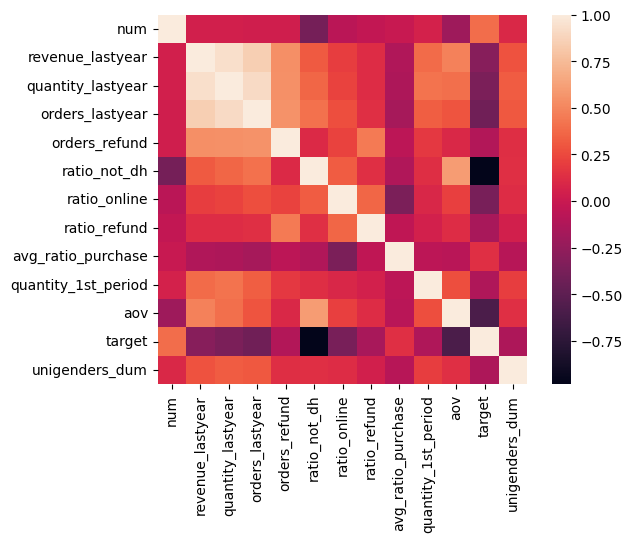

In [33]:
# отрисовываем квадратную матрицу с лейблами на осях
sns.heatmap(corr_1, square = True, xticklabels = df_2.columns, yticklabels = df_2.columns)

In [85]:
# найдём значения колонок для 2% и 98% квантиля (примем их как границы выборки)  
bounds = {
    c: dict(
        zip(["q1", "q3"], df_2.approxQuantile(c, [0.02, 0.98], 0))
    )
    for c in df_2.columns
}
bounds

{'num': {'q1': 2.0, 'q3': 14.0},
 'revenue_lastyear': {'q1': 0.0, 'q3': 187515.0},
 'quantity_lastyear': {'q1': 0.0, 'q3': 17.0},
 'orders_lastyear': {'q1': 0.0, 'q3': 9.0},
 'orders_refund': {'q1': 0.0, 'q3': 1.0},
 'ratio_not_dh': {'q1': 0.0, 'q3': 1.0},
 'ratio_online': {'q1': 0.0, 'q3': 1.0},
 'ratio_refund': {'q1': 0.0, 'q3': 0.5},
 'avg_ratio_purchase': {'q1': 0.44444444444444436, 'q3': 1.0},
 'quantity_1st_period': {'q1': 1.0, 'q3': 9.0},
 'aov': {'q1': 0.0, 'q3': 43786.5},
 'target': {'q1': 0.0, 'q3': 1.0},
 'unigenders_dum': {'q1': 0.0, 'q3': 1.0}}

In [94]:
# граничные значения выборки для столбцов с учётом iqr
for c in bounds:
    iqr = bounds[c]['q3'] - bounds[c]['q1']
    bounds[c]['lower'] = bounds[c]['q1'] - (iqr * 1.5)
    bounds[c]['upper'] = bounds[c]['q3'] + (iqr * 1.5)
bounds

{'num': {'q1': 2.0, 'q3': 14.0, 'lower': -16.0, 'upper': 32.0},
 'revenue_lastyear': {'q1': 0.0,
  'q3': 187515.0,
  'lower': -281272.5,
  'upper': 468787.5},
 'quantity_lastyear': {'q1': 0.0, 'q3': 17.0, 'lower': -25.5, 'upper': 42.5},
 'orders_lastyear': {'q1': 0.0, 'q3': 9.0, 'lower': -13.5, 'upper': 22.5},
 'orders_refund': {'q1': 0.0, 'q3': 1.0, 'lower': -1.5, 'upper': 2.5},
 'ratio_not_dh': {'q1': 0.0, 'q3': 1.0, 'lower': -1.5, 'upper': 2.5},
 'ratio_online': {'q1': 0.0, 'q3': 1.0, 'lower': -1.5, 'upper': 2.5},
 'ratio_refund': {'q1': 0.0, 'q3': 0.5, 'lower': -0.75, 'upper': 1.25},
 'avg_ratio_purchase': {'q1': 0.44444444444444436,
  'q3': 1.0,
  'lower': -0.388888888888889,
  'upper': 1.8333333333333335},
 'quantity_1st_period': {'q1': 1.0, 'q3': 9.0, 'lower': -11.0, 'upper': 21.0},
 'aov': {'q1': 0.0, 'q3': 43786.5, 'lower': -65679.75, 'upper': 109466.25},
 'target': {'q1': 0.0, 'q3': 1.0, 'lower': -1.5, 'upper': 2.5},
 'unigenders_dum': {'q1': 0.0, 'q3': 1.0, 'lower': -1.5, 'u

In [100]:
# убираем значения в колонках, ниже нижней и выше верхней границ
df_new = df_2
for col in df_2.columns: 
    df_new = (df_new.filter(F.col(col) > bounds[col]['lower'])
             .filter(F.col(col) < bounds[col]['upper']))
    print(col)

num
revenue_lastyear
quantity_lastyear
orders_lastyear
orders_refund
ratio_not_dh
ratio_online
ratio_refund
avg_ratio_purchase
quantity_1st_period
aov
target
unigenders_dum


In [ ]:
## УБРАТЬ ЦЕЛЕВОЙ СТОЛБЕЦ, КОРРЕЛЯЦЦИ, СТАНДАРТИЗАЦИЯ, МАСШТАБИРОВАНИЕ, РАЗБИВКА, ОБУЧЕНИЕ ML, ОЦЕНКА, FEATURE_IMP